# Amtrak Reviews Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Executive Summary

The goal of this analysis is to look at customer reviews of Amtrak's train service to analyze how customers feel about them. By scraping TripAdvisor, Yelp, and other discussion forums, I aim to look at how the customer experience is on Amtrak and what the company can do better to enhance the experience to bring back the train transport system in America!

## Data Scraping & Dataset Formation

In [2]:
!pip install vaderSentiment
!pip install transformers
!pip install sentencepiece
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 138.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00


In [3]:
#from scrape import add_reviews_to_dict, print_review_count
import pandas as pd
import numpy as np
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import nltk
from nltk.corpus import stopwords
from pprint import pprint
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS

In [ ]:
stops = ['2 S Station', 'Boston, MA 02111', 'Yelp users haven’t asked any questions yet about Amtrak.', 'Start your review of Amtrak.']
reviews = {}

In [ ]:
# Scrape reviews off Yelp and add valid reviews to list
add_reviews_to_dict(0, 90, step=10, base_url='https://www.yelp.com/biz/amtrak-boston-3?start={}',
                    tag_type='span', class_names='raw__09f24__T4Ezm', stop_list=stops, review_dct=reviews)

In [ ]:
# Loop through each page fo Trustpilot and add valid reviews to the list
add_reviews_to_dict(1, 30, base_url="https://www.trustpilot.com/review/www.amtrak.com?page={}",
                              tag_type='p', review_dct=reviews,
                              class_names='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn',
                              stop_list=stops,
                              attrs={'data-service-review-text-typography': 'true'})

In [ ]:
# Loop through each page fo ComplaintsBoard.com and add valid reviews to the list
add_reviews_to_dict(1, 13, base_url="https://www.complaintsboard.com/amtrak-b106889/page/{}",
                              tag_type='p', review_dct=reviews,
                              class_names='complaint-main__text',
                              stop_list=stops)

In [ ]:
# Loop through each page fo Site Jabber.com and add valid reviews to the list
add_reviews_to_dict(0, 1, base_url="https://www.sitejabber.com/reviews/amtrak.com",
                              tag_type='p', review_dct=reviews,
                              stop_list=stops)

In [ ]:
# Export data to dataframe
rows = []
# Loop through the dictionary and extract website_name and review
for website_name, review_list in reviews.items():
    for r in review_list:
        rows.append({'Website': website_name, 'Review': r})

# Create the DataFrame
df = pd.DataFrame(rows)

In [ ]:
# Store as CSV file
df.to_csv('/Users/srihariraman/PycharmProjects/Amtrak Twitter Analysis/Amtrak-Twitter-Analysis/reviews.csv')

## Pre-Processing EDA

In [4]:
# Load dataset via CSV when offline
#df = pd.read_csv("reviews.csv")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Amtrak Analysis/reviews.csv")

In [5]:
df.tail()

,Unnamed: 0,Website,Review
1182,1182,sitejabber.com,On Friday December 30th we made a reservation ...
1183,1183,sitejabber.com,The passengers are the culprits here... not th...
1184,1184,sitejabber.com,Gain trust and grow your business with custome...
1185,1185,sitejabber.com,"House Rules: On our Facebook page, we want our..."
1186,1186,sitejabber.com,Claim your listing for free to respond to revi...


In [6]:
df.shape

(1187, 3)

In [7]:
df.nunique()

Unnamed: 0    1187
Website          4
Review        1037
dtype: int64

In [8]:
df.columns

Index(['Unnamed: 0', 'Website', 'Review'], dtype='object')

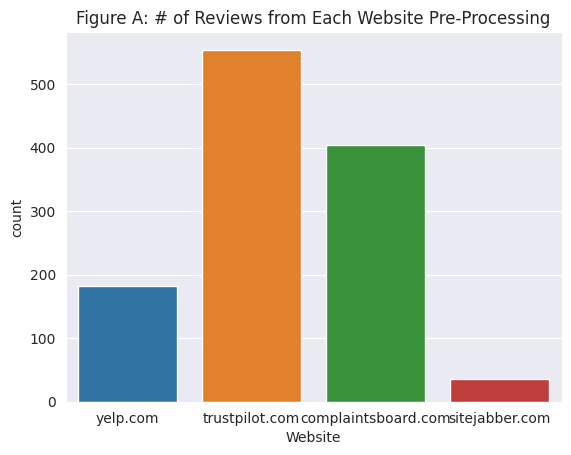

In [27]:
# Analyze count for number of reviews for each website
sns.set_style('darkgrid')
sns.countplot(data=df, x='Website')
plt.title('Figure A: Number of Reviews from Each Website Pre-Processing');

## Data Processing

In [9]:
def filter_emojis(text):
  '''
  Filters emojis from specified string and returns processed string

    Parameters:
      text (str): String to filter emojis from

    Returns:
      filtered_txt (str): Processed string
  '''

   # Remove emojis
  emoji_pattern = re.compile("["
      u"\U0001F600-\U0001F64F"  # emoticons
      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
      u"\U0001F680-\U0001F6FF"  # transport & map symbols
      u"\U0001F700-\U0001F77F"  # alchemical symbols
      u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
      u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
      u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
      u"\U0001FA00-\U0001FA6F"  # Chess Symbols
      u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
      u"\U0001F680-\U0001F6FF"  # Emojis
                          "]+", flags=re.UNICODE)
  emoji_pattern.sub(r'', text)  # Replace emojis with empty string

  # Return processed string
  return text.lower().strip()

In [10]:
nltk.download('stopwords')
def filter_stops_tokenize(text):
  '''
  Filters stopwords (using NLTK stopwords library) from specified string and
  tokenizes t

    Parameters:
      text (str): String to filter stop words from

    Returns:
      filter_tokens (list): List of tokenized words from the text
  '''
  stop_words = set(stopwords.words('english'))
  return [w for w in text.split() if w not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Remove punctuation from reviews
df['review_processed'] = df['Review'].str.replace('[^\w\s]', '', regex=True)

In [12]:
# Apply processing to reviews
df['review_processed'] = df['Review'].apply(filter_emojis)

In [13]:
# Tokenize processed reviews with stop word filtration
df['tok_processed_reviews'] = df['review_processed'].apply(filter_stops_tokenize)

In [14]:
# Store the review polarity and subjectivity for each review
sid_obj= SentimentIntensityAnalyzer()
df['review_polarity'] = [sid_obj.polarity_scores(review)['compound'] for review in df['review_processed']]
df['review_subjectivity'] = [TextBlob(review).sentiment.subjectivity for review in df['review_processed']]

In [15]:
# Drop unknown column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [16]:
df.shape

(1187, 6)

### Review Filtering: Outlier Detection & Zero-Shot Text Classification

The solution used to filter unrelated reviews is done in a two-step manner. Step 1 consists of detecting outliers for the subjectivity score with Q1, Q3, and IQR values computed across the dataset. In the process, I also removed reviews in which the polarity was exceptionally high (0.9 or greater).

Step 2 in this process used a zero-shot classification model from the HuggingFace pre-trained model library to compute the probability that the review was about Amtrak's service. Using the DistilBERT model found [here](https://huggingface.co/typeform/distilbert-base-uncased-mnli), I further filtered out reviews in which the probability calculated was less than 50%.


However, the dataset could still be contaminated as this entire process was automated. I have not manually removed reviews due to the size of the dataset.

In [17]:
# Define outlier threshold for filtration
Q1p = df['review_subjectivity'].quantile(0.25)
Q3p = df['review_subjectivity'].quantile(0.75)
IQRp = Q3p - Q1p
lower = Q1p - 0.5*IQRp
upper = Q3p + 0.5*IQRp

# Add indexes where outlier condition is met
stop_indexes = list(np.where(df['review_subjectivity'] >= upper)[0]) + list(np.where(df['review_subjectivity'] <= lower)[0])

# Only keep stop indexes in which polarity is exceptionally high
stop_indexes = [i for i in stop_indexes if i in np.where(df['review_polarity'] >= 0.9)[0]]

In [18]:
def zeroshot_classification_prob(review):
  '''
  Performs zero-shot classification and returns the probability of target label
  classification is met according to the defined labels.

  Model used is developed by Hugging Face using the DistilBERT Uncased pre-trained
  on the MNLI dataset

    Parameters:
      review (str): Review to classify

    Returns:
      prob (float): Probability that the text is about the target label
  '''
  candidate_labels = ['Amtrak', 'Not Amtrak']

  classifier = pipeline("zero-shot-classification", model='typeform/distilbert-base-uncased-mnli')
  result = classifier(review, candidate_labels)
  return result['scores'][result['labels'].index('Amtrak')]

In [19]:
# Calculate the classification probability of review being about
stop_indexes = [i for i in stop_indexes if zeroshot_classification_prob(df.loc[i,'review_processed']) < 0.5]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from you

In [20]:
# Drop all rows found in stop_indexes list
df.drop(index=stop_indexes, inplace=True)

In [21]:
df.tail(10)

,Website,Review,review_processed,tok_processed_reviews,review_polarity,review_subjectivity
1177,sitejabber.com,Amtrack has the worst attitude employees in th...,amtrack has the worst attitude employees in th...,"[amtrack, worst, attitude, employees, world, t...",-0.7475,0.766667
1178,sitejabber.com,I wanted to change my reservation to get on th...,i wanted to change my reservation to get on th...,"[wanted, change, reservation, get, train, one,...",-0.8122,0.335714
1179,sitejabber.com,They were amazing. Not only is it a smooth rid...,they were amazing. not only is it a smooth rid...,"[amazing., smooth, ride, also, nice, sweet., m...",0.9725,0.677083
1180,sitejabber.com,I waited one hour to talk to anyone about one ...,i waited one hour to talk to anyone about one ...,"[waited, one, hour, talk, anyone, one, small, ...",-0.8858,0.600000
1181,sitejabber.com,All carts of amtrak regional 177 smell like ur...,all carts of amtrak regional 177 smell like ur...,"[carts, amtrak, regional, 177, smell, like, ur...",-0.0258,0.000000
1182,sitejabber.com,On Friday December 30th we made a reservation ...,on friday december 30th we made a reservation ...,"[friday, december, 30th, made, reservation, am...",-0.5719,0.800000
1183,sitejabber.com,The passengers are the culprits here... not th...,the passengers are the culprits here... not th...,"[passengers, culprits, here..., rr.]",0.0000,0.000000
1184,sitejabber.com,Gain trust and grow your business with custome...,gain trust and grow your business with custome...,"[gain, trust, grow, business, customer, reviews.]",0.7717,0.000000
1185,sitejabber.com,"House Rules: On our Facebook page, we want our...","house rules: on our facebook page, we want our...","[house, rules:, facebook, page,, want, riders,...",0.9242,0.700000
1186,sitejabber.com,Claim your listing for free to respond to revi...,claim your listing for free to respond to revi...,"[claim, listing, free, respond, reviews,, upda...",0.5106,0.800000


In [20]:
# Export cleaned data to CSV file
df.to_csv('reviews_cleaned.csv')

## Analysis

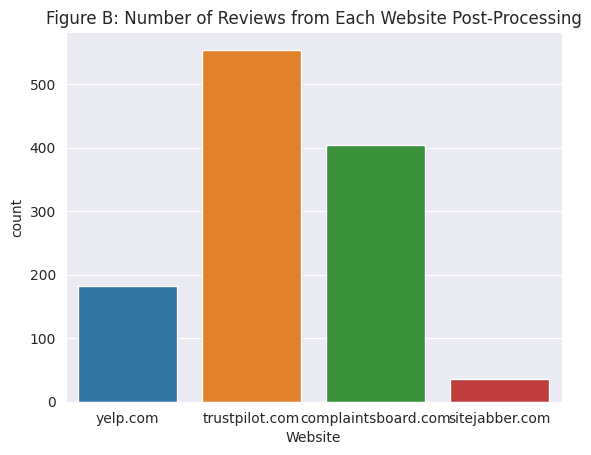

In [22]:
# Analyze count for number of reviews for each website after processing
sns.set_style('darkgrid')
sns.countplot(data=df, x='Website')
plt.title('Figure B: Number of Reviews from Each Website Post-Processing');

Post-processing, we can see that Amtrak reviews are not equally balanced in this dataset, with there being class imbalance in the number of reviews originating from each website. TrustPilot and ComplaintsBoard make up a majority of the reviews, hence meaning that polarity and sentiment metrics calculated are likely to be more biased towards these reviews.

Text(0.5, 1.0, 'Distribution of Overall Polarity Score')

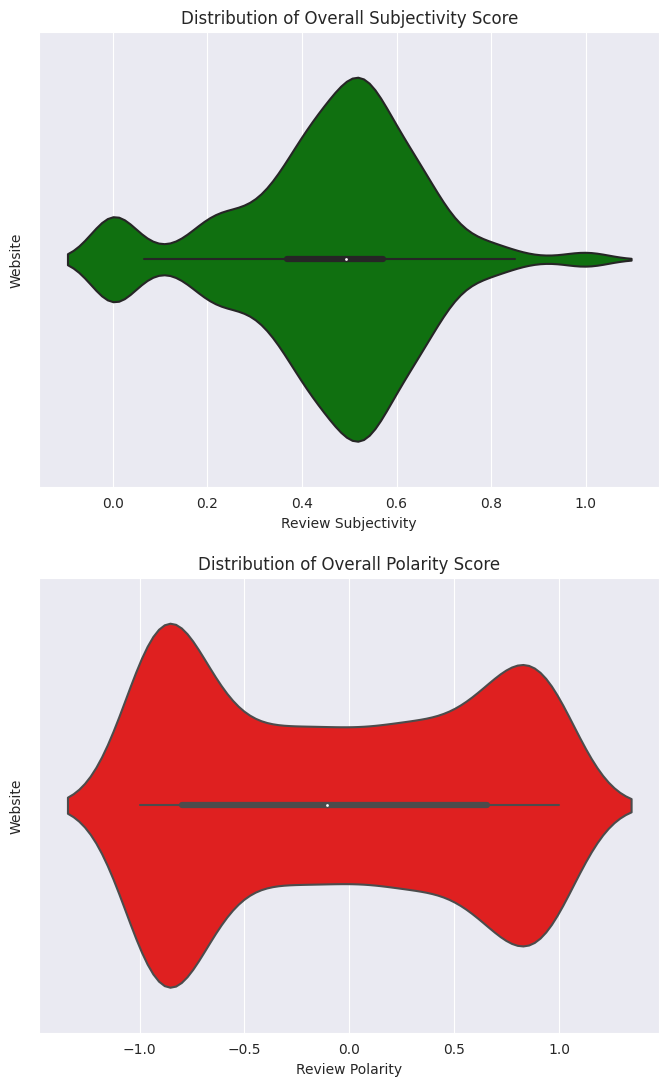

In [23]:
# Overall distribution of polarity and subjectivity
fig, ax = fig, ax = plt.subplots(2,1, figsize=(8, 13))
sns.violinplot(data=df, x='review_subjectivity', ax = ax[0], color='green')
ax[0].set_xlabel('Review Subjectivity')
ax[0].set_ylabel('Website')
ax[0].set_title('Distribution of Overall Subjectivity Score')

sns.violinplot(data=df, x='review_polarity', ax= ax[1], color='red')
ax[1].set_xlabel('Review Polarity')
ax[1].set_ylabel('Website')
ax[1].set_title('Distribution of Overall Polarity Score')

In [24]:
print("Average Polarity Score: ", df['review_polarity'].mean())
print("Average Subjectivity Score: ", df['review_subjectivity'].mean())

Average Polarity Score:  -0.06010544217687077
Average Subjectivity Score:  0.4555905515213067


Overall, Amtrak's customer reviews are either skewed more negatively or positively, with the overall outlook being more negative than positive. The overall sentiment score is centered more around -1.0 and 0.7, thus meaning that customers either had a great experience or a very negative experience.

In contrast, the overall subjectivity score distribution is more unimodal, centered around approximately 0.5. This means that, overall, customer reviews were balanced in terms of opinionated or fact-based.

Text(0.5, 1.0, 'Distribution of Polarity Scores Grouped by Website')

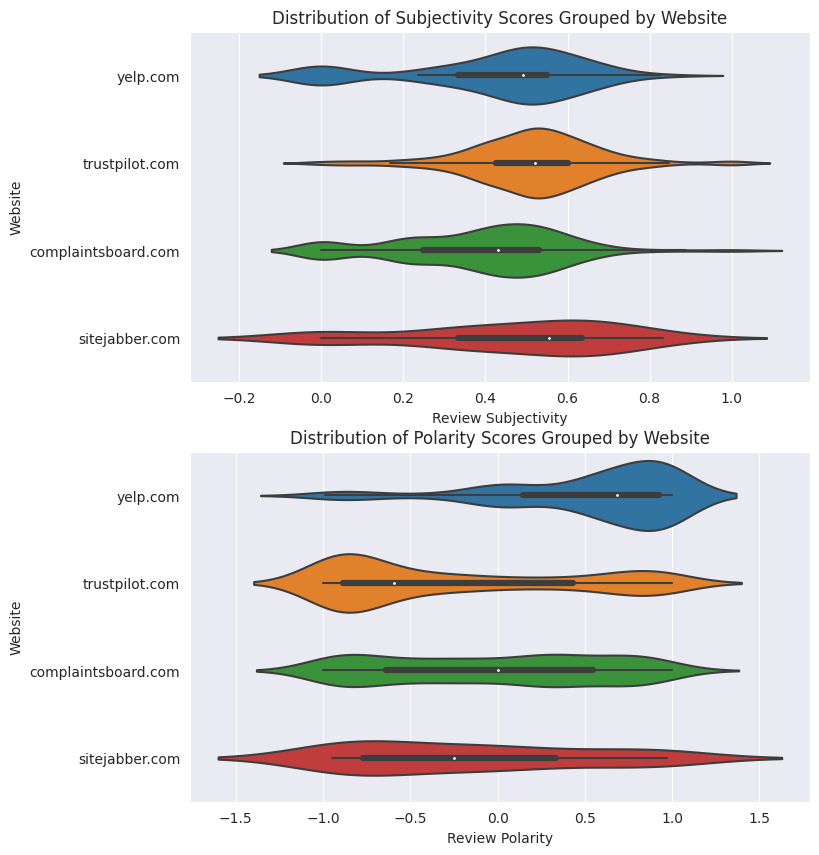

In [25]:
# Distribution of polarity and sentiment scores grouped by website
fig, ax = plt.subplots(2,1, figsize=(8, 10))
sns.violinplot(data=df, x='review_subjectivity', y='Website', ax = ax[0])
ax[0].set_xlabel('Review Subjectivity')
ax[0].set_ylabel('Website')
ax[0].set_title('Distribution of Subjectivity Scores Grouped by Website')

sns.violinplot(data=df, x='review_polarity', y='Website', ax= ax[1])
ax[1].set_xlabel('Review Polarity')
ax[1].set_ylabel('Website')
ax[1].set_title('Distribution of Polarity Scores Grouped by Website')

In [26]:
# Descriptive statistics of polarity and subjectivity
df.groupby("Website").describe()['review_polarity']

,count,mean,std,min,25%,50%,75%,max
Website,,,,,,,,
complaintsboard.com,404.0,-0.027542,0.633918,-0.9995,-0.639825,0.00000,0.546075,0.9994
sitejabber.com,36.0,-0.167992,0.670561,-0.9458,-0.771100,-0.24765,0.334050,0.9725
trustpilot.com,554.0,-0.269667,0.705131,-0.9983,-0.885225,-0.59090,0.433350,0.9978
yelp.com,182.0,0.526847,0.519603,-0.9905,0.143000,0.68680,0.926275,0.9988


In [27]:
df.groupby("Website").describe()['review_subjectivity']

,count,mean,std,min,25%,50%,75%,max
Website,,,,,,,,
complaintsboard.com,404.0,0.387645,0.202598,0.0,0.247222,0.429488,0.529498,1.000000
sitejabber.com,36.0,0.461905,0.257594,0.0,0.333415,0.555878,0.634875,0.833333
trustpilot.com,554.0,0.514892,0.163768,0.0,0.424530,0.520905,0.600000,1.000000
yelp.com,182.0,0.424657,0.214508,0.0,0.332718,0.492674,0.550000,0.826667


Analyzing by website, we see that 3 of 4 analyzed websites are skewed more negatively, with the distribution of average review sentiment scores for the 3 websites being centered more around -1.0. However, the only website to have more positive reviews is Yelp.com. This could pose an interesting question as to whether or not Yelp reviews are actually made by consumers who've experienced journeys on Amtrak.

Similarly, the subjectivity scores of the websites are relatively similar in that their distributions are approximately unimodal and centered around 0.5. However, SiteJabber seems to lean more towards fact-based evidence. Through descriptive analysis (see tables above), we can see than 75% of review sentiment scores being centered between 0.52-0.63. Thus, we can see that of the four websites analyzed in this project, most of the reviews are neutral in terms of being opinionated and fact-based.

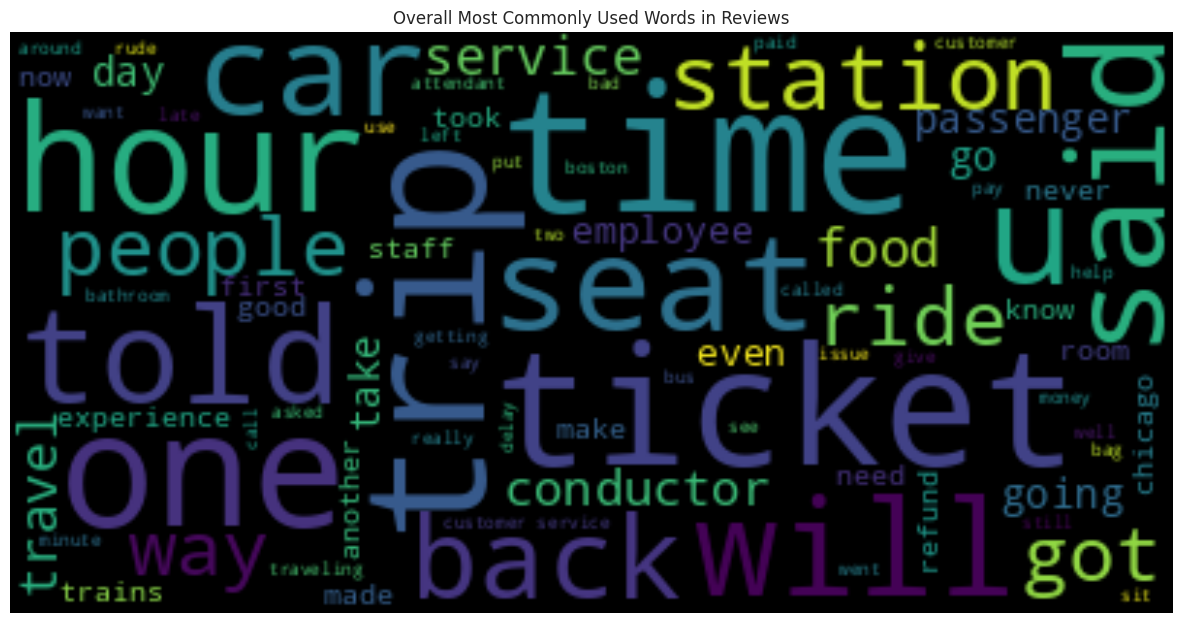

In [28]:
# WordCloud for most common word used in all reviews
stopwords = set(list(STOPWORDS) + ["amtrak", "train"])
fig = plt.figure(figsize=(15,10))

text = " ".join(review for review in df['review_processed'])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=60, max_words=80, stopwords=stopwords,
                      background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Overall Most Commonly Used Words in Reviews")
plt.show()

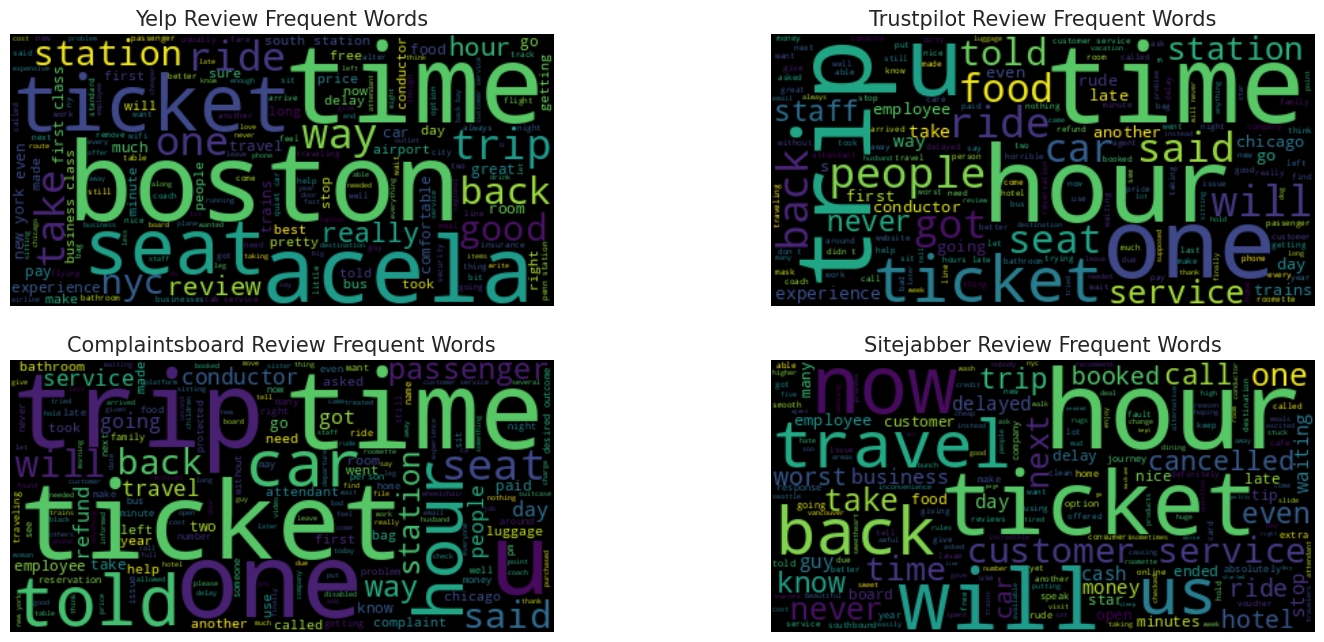

In [29]:
# WordCloud for each website
fig = plt.figure(figsize=(18,12))

k = 0
websites = [w for w in df['Website'].unique()]

while k <=3:
  plt.subplot(3, 2, k+1)
  w = WordCloud(
    background_color='black',
    stopwords=stopwords,
    max_words=500,
    max_font_size=80,
    random_state=42
    ).generate(" ".join(review for review in df[df['Website'] == websites[k]]['review_processed']))

  plt.imshow(w, interpolation='bilinear')
  plt.title(f'{websites[k][:-4].title()} Review Frequent Words', fontsize=15)
  plt.axis('off')

  k+=1

In the analysis, I also wanted to look at which words most frequently occured in the reviews. On an aggregated level, the most apparent words were **time**, **ticket**, **trip**, and **hour**. This means that most of the reviews (by making a loose-level guess) were concerned either about train timings or trip/ticketing experiences. Becuase the overall sentiment towards Amtrak is negative, it is likely that these topics are what caused a slim majority of customers dissatisfaction.

When analyzing website-specific review content, Yelp reviews were more centered around the Acela exeperience. A lot of reviews seemed to be concerned with the Boston train, with **time** and **ticket**, and **seat** being some of the important keywords. Because Yelp was a much more positively-skewed website, it is likely that Amtrak should focus on their strengths with the Acela Express and try and cross-implement them with their other services.

Trustpilot was more concerned around the **time**, **trip**, **food**, and **people**. Because it was one of the negatively-skewed review sites, Amtrak should take a look at things like train timing, overall trip experiences, food quality/taste, and the staff that work on these trains. By improving these segments, Amtrak is likely to acquire more customer satisfaction!

Complaintsboard and Sitejabber were similar in that the overall topics concerned around timing and service on the trains.  Keywords in these reviews included **ticket**, **time**, **customer**, and **experience**. This likely means that customers posting on this site had an issue with train timing/scheduling and customer service. Amtrak should analyze the customer service experience they are providing—customer service representatives, train staff, etc.—and should focus on improving those segments as well!